In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                   QuantileTransformer, PowerTransformer)
import seaborn as sns

from htools import *
from htools import pd_tools

/Users/hmamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/hmamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/hmamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
cd_root()
sns.set_style('darkgrid')

Current directory: /Users/hmamin/stormlight


In [6]:
!ls data/interim

distilbert_sentiment_scores.pkl oathbringer.txt
edge_sentiment_scores.csv       the_way_of_kings.txt
edgedancer.txt                  war_sentiment_scores.csv
kings_sentiment_scores.csv      warbreaker.txt
mistborn_the_final_empire.txt   words_of_radiance.txt
oath_sentiment_scores.csv       words_sentiment_scores.csv


In [42]:
scorers = ['vader', 'pattern', 'huggingface', 'naive']
score_cols = [(s, 'score') for s in scorers]

In [43]:
df = DotDict((path.split('/')[-1].split('_')[0], 
              pd.read_csv(path, header=[0, 1]))
             for path in glob('data/interim/*sentiment_scores.csv'))

In [44]:
df.kings.head()

vader                            pattern        huggingface            \
     neg    neu    pos   score subjectivity  score       label     score   
0  0.091  0.909  0.000 -0.2960     0.000000  0.000    NEGATIVE -0.992950   
1  0.171  0.829  0.000 -0.4767     0.650000 -0.200    NEGATIVE -0.996405   
2  0.000  1.000  0.000  0.0000     0.450000 -0.275    NEGATIVE -0.519531   
3  0.103  0.812  0.085 -0.1027     0.266667  0.000    NEGATIVE -0.836902   
4  0.000  1.000  0.000  0.0000     0.000000  0.000    NEGATIVE -0.999556   

           naive                                
  classification     p_pos     p_neg     score  
0            pos  0.982303  0.017697  0.982303  
1            neg  0.442419  0.557581 -0.557581  
2            neg  0.005532  0.994468 -0.994468  
3            pos  0.829290  0.170710  0.829290  
4            pos  0.569950  0.430050  0.569950

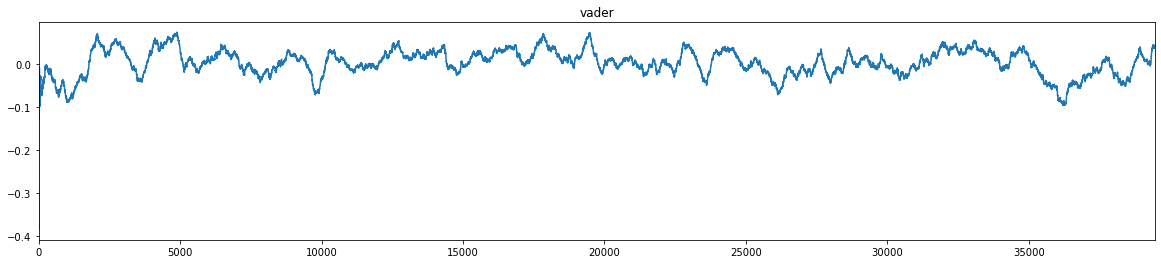

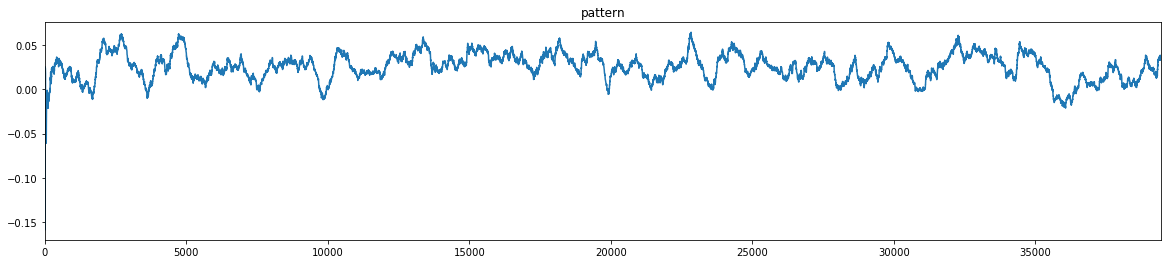

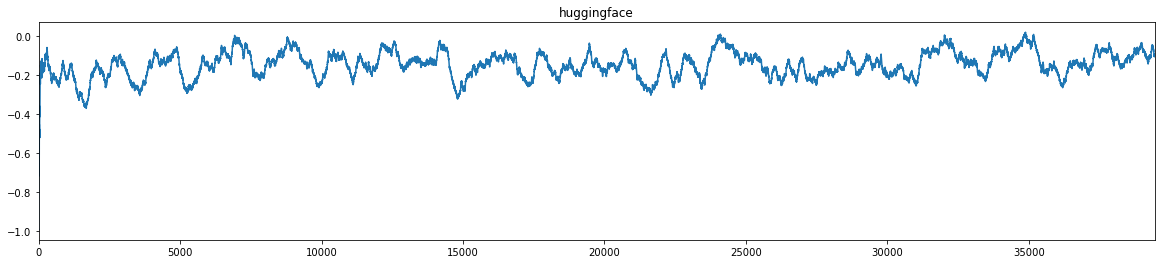

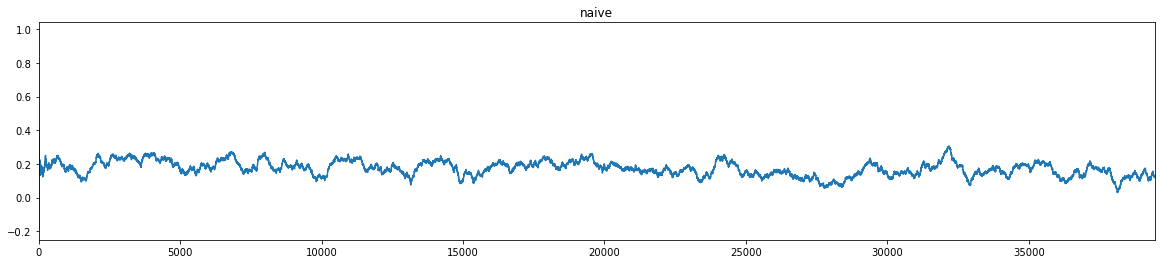

In [47]:
for scorer in scorers:
#     df.kings[scorer].score.plot(figsize=(20, 4), lw=.25, alpha=.25)
#     df.kings[scorer].score.ewm(alpha=.01).mean().plot()
    df.kings[scorer].score.ewm(alpha=1/375, adjust=True).mean().plot(figsize=(20, 4))
    plt.title(scorer)
    plt.show()

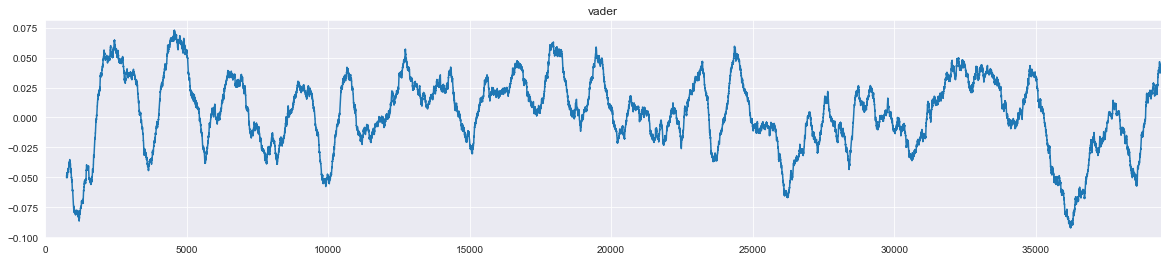

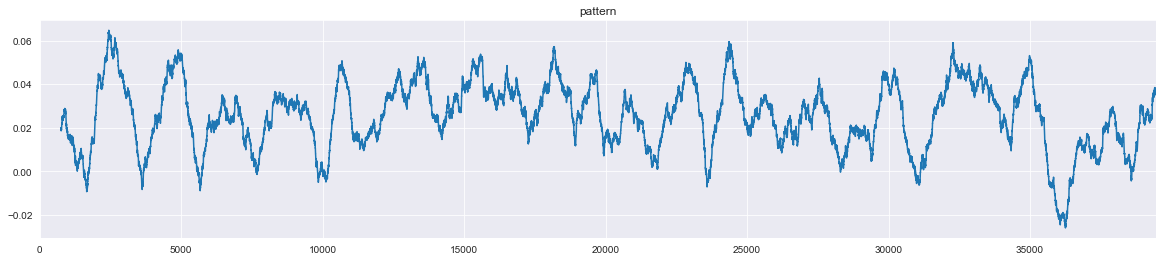

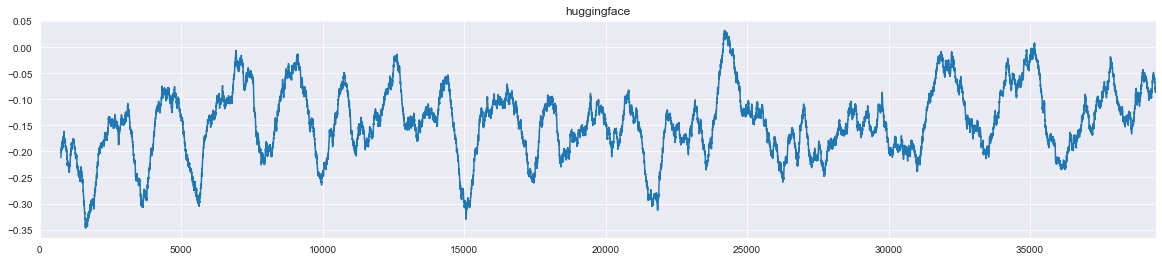

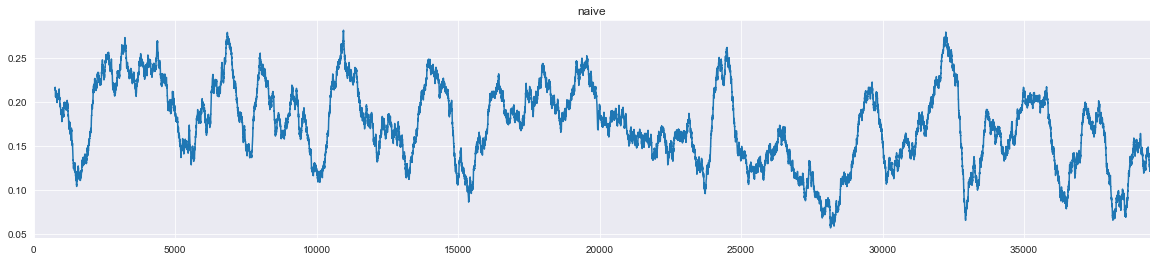

In [66]:
for scorer in scorers:
    df.kings[scorer].score.rolling(750).mean().plot(figsize=(20, 4))
    plt.title(scorer)
    plt.show()

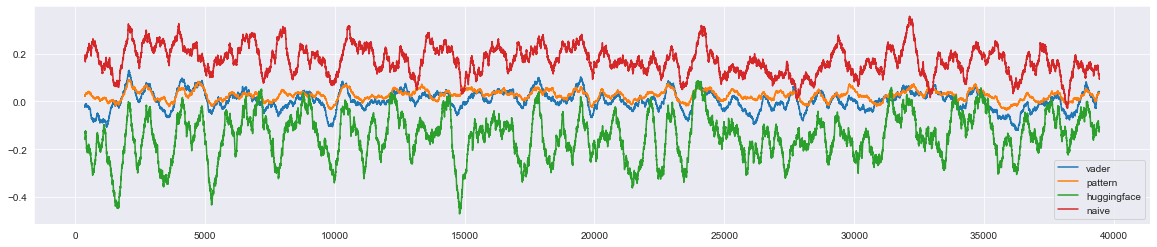

In [50]:
fig, ax = plt.subplots(figsize=(20, 4))
for scorer in scorers:
    ax.plot(df.kings[scorer].score.rolling(375).mean(), label=scorer)
plt.legend()
plt.show()

In [53]:
for k, v in df.items():
    print(k)
    cols = v[score_cols]
    cols.corr().pprint()
    cols.describe(percentiles=[.5]).pprint()
    print(spacer())

kings


,,vader,pattern,huggingface,naive
,,score,score,score,score
vader,score,1.000000,0.400801,0.341743,0.068725
pattern,score,0.400801,1.000000,0.207518,0.107292
huggingface,score,0.341743,0.207518,1.000000,0.109398
naive,score,0.068725,0.107292,0.109398,1.000000


,vader,pattern,huggingface,naive
,score,score,score,score
count,39444.000000,39444.000000,39444.000000,39444.000000
mean,0.003635,0.025499,-0.146275,0.172733
std,0.316484,0.228091,0.946385,0.663215
min,-0.979900,-1.000000,-0.999822,-0.999831
50%,0.000000,0.000000,-0.906576,0.541719
max,0.971900,1.000000,0.999890,0.999932



-------------------------------------------------------------------------------

oath


,,vader,pattern,huggingface,naive
,,score,score,score,score
vader,score,1.000000,0.397190,0.328979,0.065385
pattern,score,0.397190,1.000000,0.201147,0.126476
huggingface,score,0.328979,0.201147,1.000000,0.118825
naive,score,0.065385,0.126476,0.118825,1.000000


,vader,pattern,huggingface,naive
,score,score,score,score
count,46022.000000,46022.000000,46022.000000,46022.000000
mean,0.010923,0.030182,-0.106657,0.179638
std,0.311430,0.231007,0.952024,0.663511
min,-0.955900,-1.000000,-0.999818,-0.999091
50%,0.000000,0.000000,-0.857061,0.543470
max,0.962800,1.000000,0.999894,0.999935



-------------------------------------------------------------------------------

war


,,vader,pattern,huggingface,naive
,,score,score,score,score
vader,score,1.000000,0.419358,0.337284,0.057141
pattern,score,0.419358,1.000000,0.183728,0.097083
huggingface,score,0.337284,0.183728,1.000000,0.103869
naive,score,0.057141,0.097083,0.103869,1.000000


,vader,pattern,huggingface,naive
,score,score,score,score
count,21930.000000,21930.000000,21930.000000,21930.000000
mean,0.018597,0.030256,-0.070732,0.141055
std,0.307459,0.230652,0.960213,0.654786
min,-0.935000,-1.000000,-0.999822,-0.998620
50%,0.000000,0.000000,-0.812387,0.515058
max,0.968900,1.000000,0.999888,0.999818



-------------------------------------------------------------------------------

edge


,,vader,pattern,huggingface,naive
,,score,score,score,score
vader,score,1.000000,0.439587,0.330263,0.073304
pattern,score,0.439587,1.000000,0.219105,0.131983
huggingface,score,0.330263,0.219105,1.000000,0.116649
naive,score,0.073304,0.131983,0.116649,1.000000


,vader,pattern,huggingface,naive
,score,score,score,score
count,5500.000000,5500.000000,5500.000000,5500.000000
mean,0.007554,0.028156,-0.135160,0.113181
std,0.282247,0.238495,0.951605,0.666582
min,-0.952800,-1.000000,-0.999811,-0.997125
50%,0.000000,0.000000,-0.905550,0.523245
max,0.961200,1.000000,0.999887,0.998656



-------------------------------------------------------------------------------

words


,,vader,pattern,huggingface,naive
,,score,score,score,score
vader,score,1.000000,0.397683,0.309196,0.064238
pattern,score,0.397683,1.000000,0.178689,0.103881
huggingface,score,0.309196,0.178689,1.000000,0.137762
naive,score,0.064238,0.103881,0.137762,1.000000


,vader,pattern,huggingface,naive
,score,score,score,score
count,46592.000000,46592.000000,46592.000000,46592.000000
mean,0.012664,0.026360,-0.034471,0.170323
std,0.285288,0.218447,0.958649,0.642919
min,-0.948500,-1.000000,-0.999822,-0.998552
50%,0.000000,0.000000,-0.666302,0.511224
max,0.948500,1.000000,0.999892,0.999943



-------------------------------------------------------------------------------



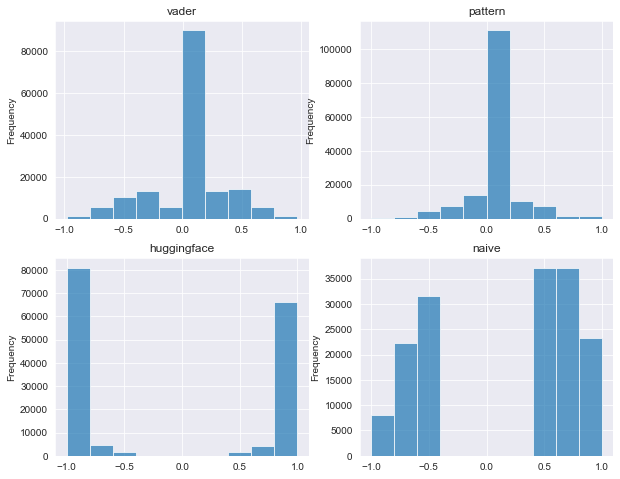

In [49]:
df_all = pd.concat(df.values())

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for cols, ax_ in zip(score_cols, ax.flatten()):
    df_all[cols].plot.hist(alpha=.7, ax=ax_)
    ax_.set_title(cols[0])
plt.show()

In [51]:
df_all['compound_score'] = (.25*df_all.vader.score + .25*df_all.pattern.score 
                            + .5*df_all.huggingface.score)
df_all.compound_score.describe()

count    159488.000000
mean         -0.036101
std           0.524015
min          -0.977094
25%          -0.498465
50%          -0.341504
75%           0.497513
max           0.983665
Name: compound_score, dtype: float64

In [53]:
qt = QuantileTransformer()
df_all['scaled_compound_score'] = qt.fit_transform(df_all[['compound_score']])

In [56]:
mm = MinMaxScaler((-1, 1))
df_all['scaled_minmax_score'] = mm.fit_transform(
    df_all[['scaled_compound_score']]
)

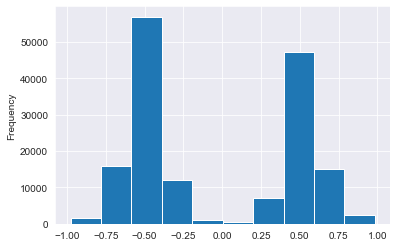

In [54]:
df_all.compound_score.plot.hist()

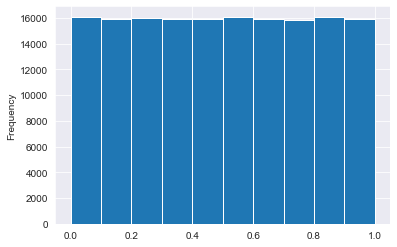

In [55]:
df_all.scaled_compound_score.plot.hist()

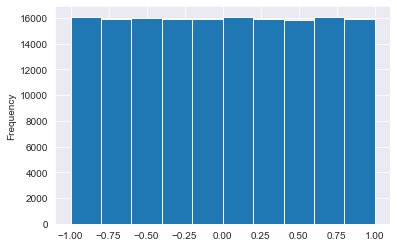

In [57]:
df_all.scaled_minmax_score.plot.hist()

In [140]:
df_all.scaled_compound_score.describe()

count    159488.000000
mean          0.500339
std           0.288522
min           0.000000
25%           0.250572
50%           0.500018
75%           0.750134
max           1.000000
Name: scaled_compound_score, dtype: float64

In [58]:
df_all.scaled_minmax_score.describe()

count    159488.000000
mean         -0.000409
std           0.577549
min          -1.000000
25%          -0.501171
50%           0.000227
75%           0.499543
max           1.000000
Name: scaled_minmax_score, dtype: float64

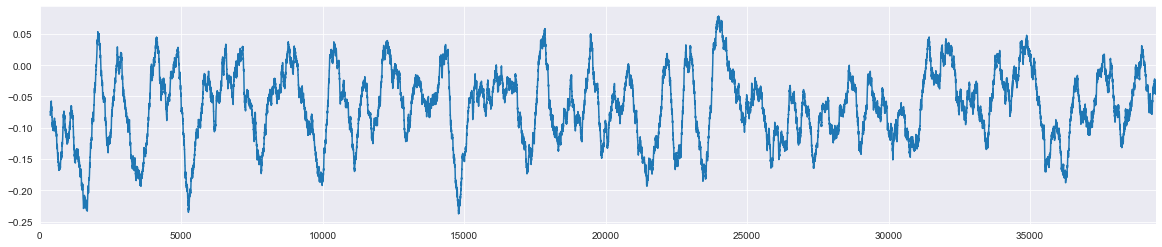

In [137]:
df_all.compound_score.reset_index(drop=True).rolling(375).mean()[:df.kings.shape[0]].plot(figsize=(20, 4))

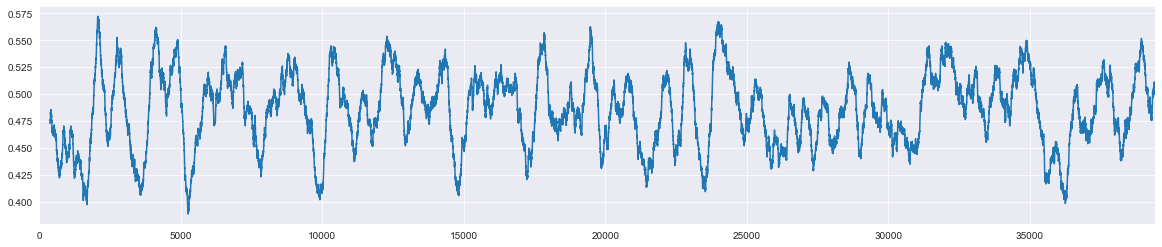

In [141]:
df_all.scaled_compound_score.reset_index(drop=True).rolling(375).mean()[:df.kings.shape[0]].plot(figsize=(20, 4))

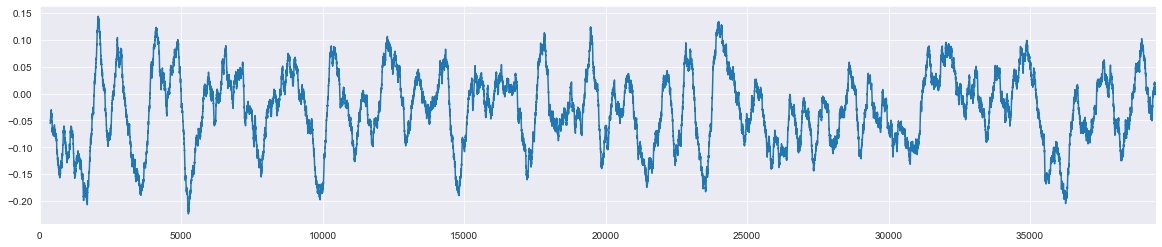

In [59]:
df_all.scaled_minmax_score.reset_index(drop=True).rolling(375).mean()[:df.kings.shape[0]].plot(figsize=(20, 4))

In [60]:
def compound_score(df, weights=(.25, .25, .5, 0.)):
    return sum(w*df[col] for w, col in zip(weights, score_cols))

In [62]:
for k, v in df.items():
    df[k]['compound_score'] = compound_score(v)
    df[k]['scaled_compound_score'] = qt.transform(df[k][['compound_score']])
    df[k]['scaled_minmax_score'] = mm.transform(df[k][['scaled_compound_score']])
    df[k].head().pprint()
    print(k, 'autocorr:', df[k].scaled_minmax_score.autocorr())

kings autocorr: 0.11002559712086465


oath autocorr: 0.09447095890880929


war autocorr: 0.09308175875819459


edge autocorr: 0.0581673173761369


words autocorr: 0.10006427649134904


In [63]:
df_all.compound_score.describe()

count    159488.000000
mean         -0.036101
std           0.524015
min          -0.977094
25%          -0.498465
50%          -0.341504
75%           0.497513
max           0.983665
Name: compound_score, dtype: float64

In [64]:
df_all.scaled_compound_score.describe()

count    159488.000000
mean          0.499795
std           0.288774
min           0.000000
25%           0.249415
50%           0.500114
75%           0.749771
max           1.000000
Name: scaled_compound_score, dtype: float64

In [65]:
df_all.scaled_minmax_score.describe()

count    159488.000000
mean         -0.000409
std           0.577549
min          -1.000000
25%          -0.501171
50%           0.000227
75%           0.499543
max           1.000000
Name: scaled_minmax_score, dtype: float64

kings


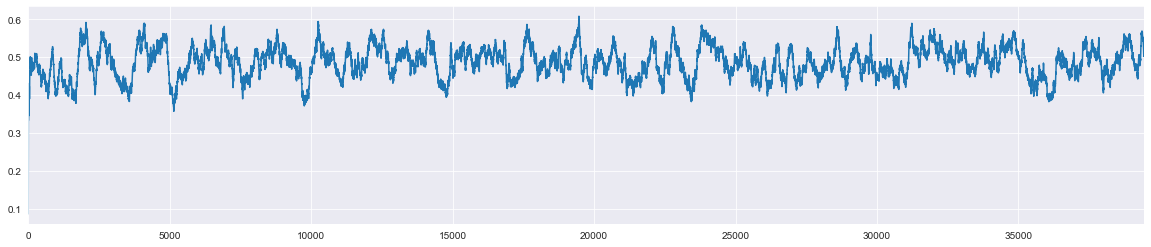

oath


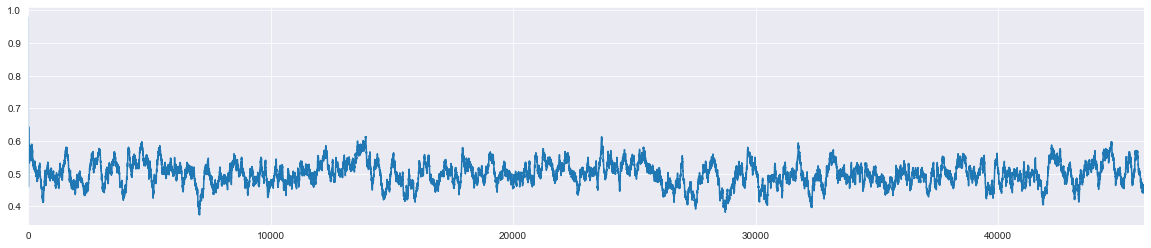

war


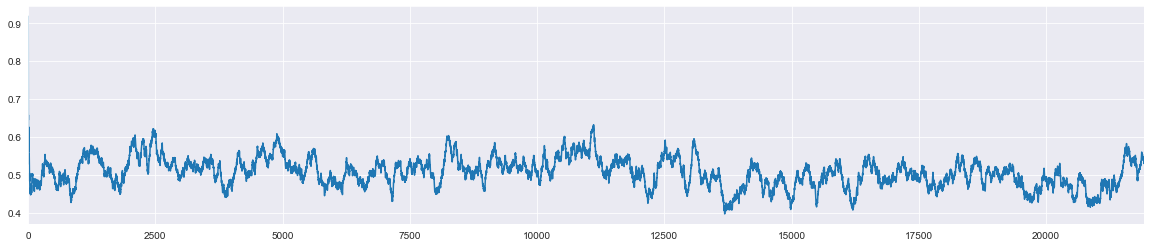

edge


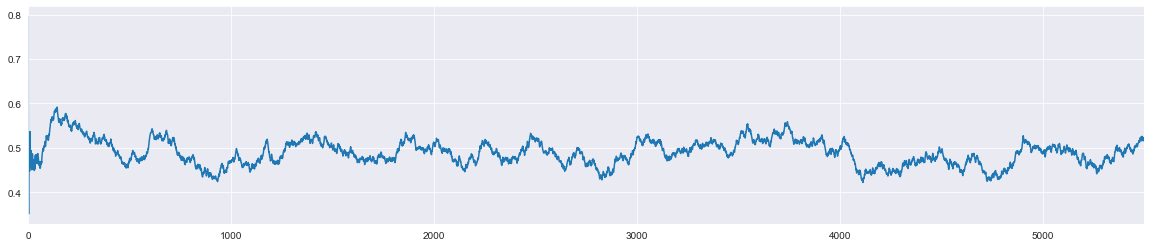

words


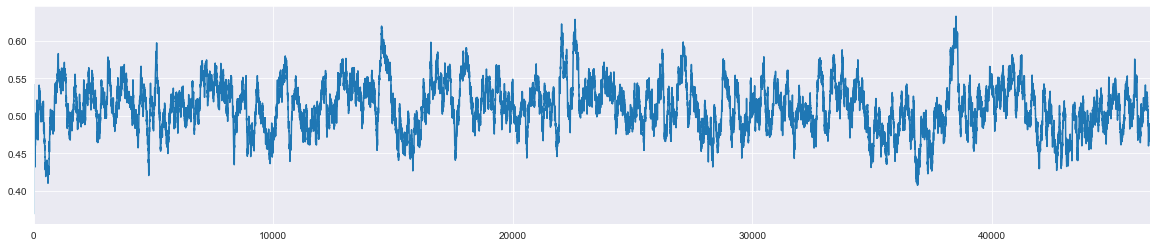

In [182]:
for k, v in df.items():
    print(k)
    v.scaled_compound_score.ewm(alpha=.01, adjust=True).mean().plot(figsize=(20, 4))
    plt.show()

kings


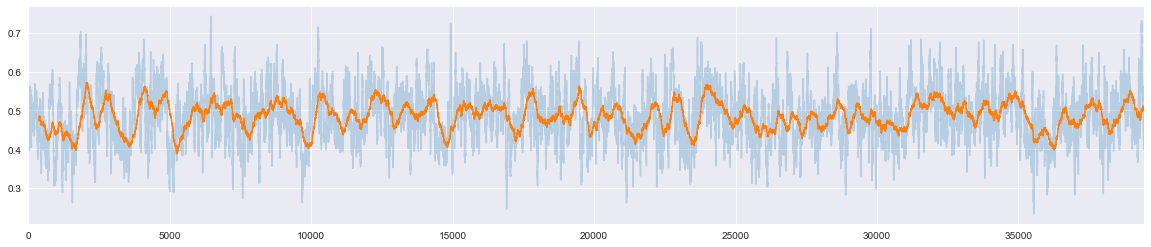

oath


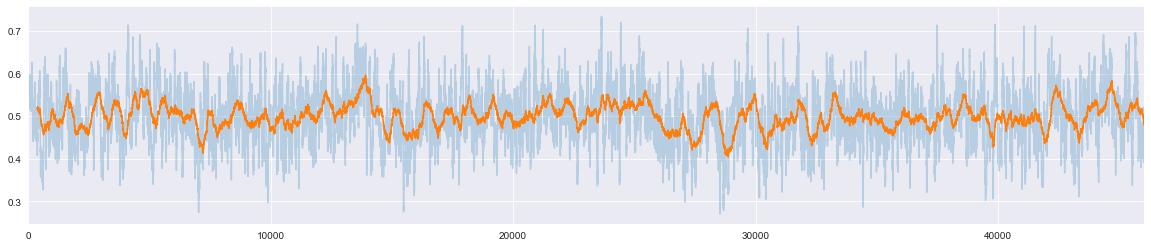

war


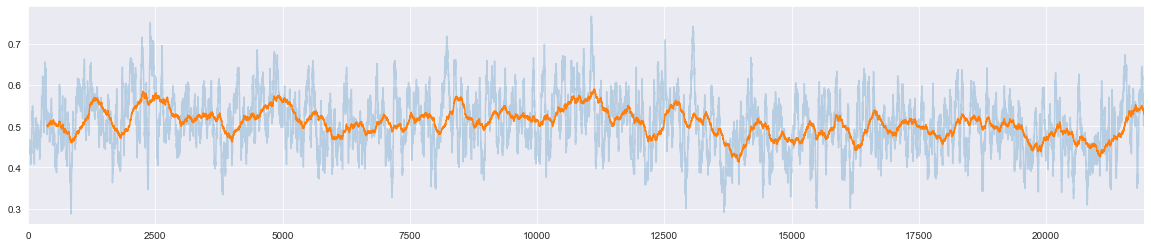

edge


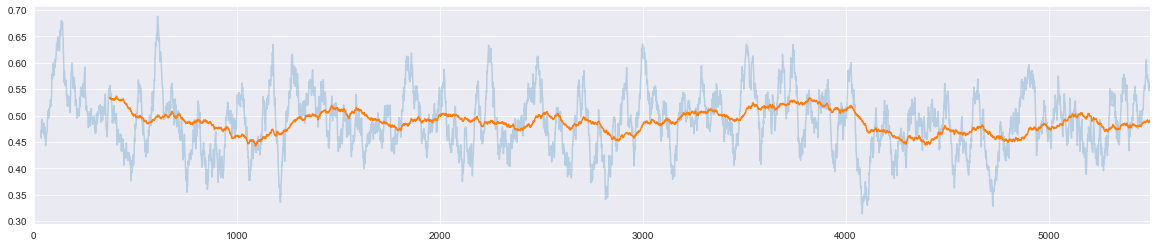

words


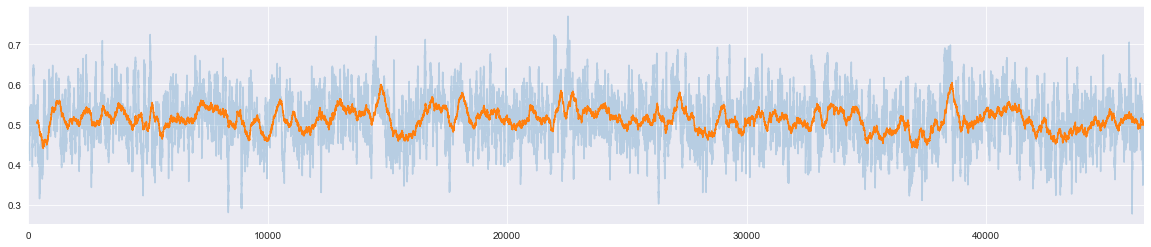

In [184]:
for k, v in df.items():
    print(k)
    v.scaled_compound_score.rolling(37).mean().plot(figsize=(20, 4), alpha=.25)
    v.scaled_compound_score.rolling(375).mean().plot()
    plt.show()

kings


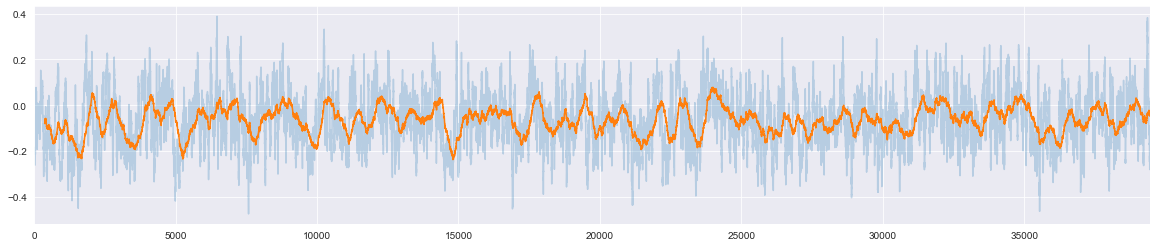

oath


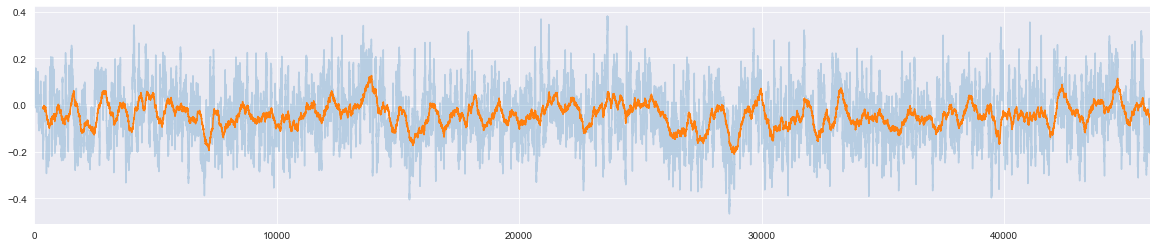

war


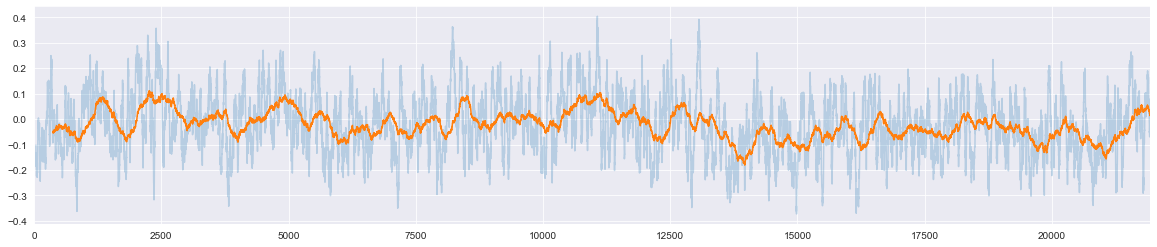

edge


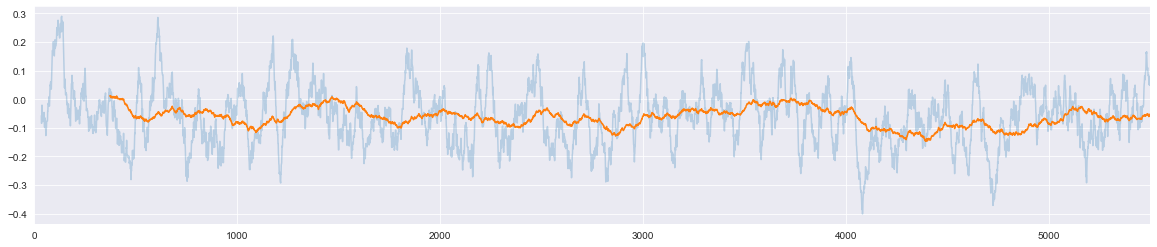

words


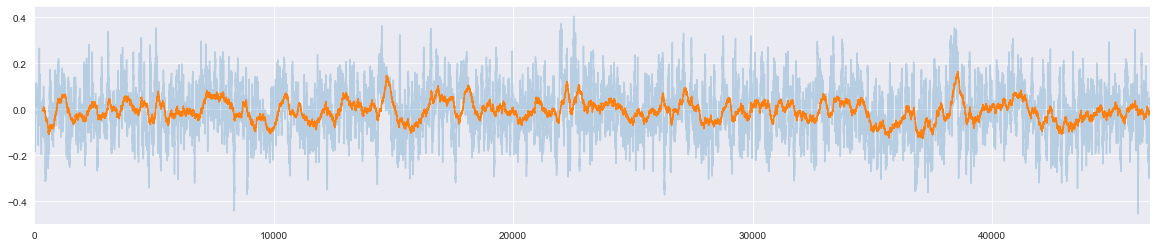

In [189]:
for k, v in df.items():
    print(k)
    v.compound_score.rolling(37).mean().plot(figsize=(20, 4), alpha=.25)
    v.compound_score.rolling(375).mean().plot()
    plt.show()

In [66]:
keep_cols = ['compound_score', 'scaled_compound_score', 'scaled_minmax_score']
book2compound = {k: v[keep_cols] for k, v in df.items()}
book2compound.keys(), book2compound['kings'].shape

(dict_keys(['kings', 'oath', 'war', 'edge', 'words']), (39444, 3))

In [68]:
save(book2compound, 'data/clean/compound_sentiment_scores.pkl')

Writing data to data/clean/compound_sentiment_scores.pkl.


In [15]:
from sklearn.preprocessing import MaxAbsScaler

In [10]:
df = load('data/clean/compound_sentiment_scores.zip')

Object loaded from data/clean/compound_sentiment_scores.zip.


In [14]:
df_all = pd.concat(df.values())

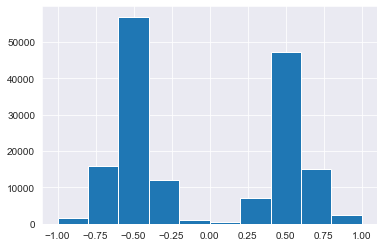

In [29]:
rescaled = MinMaxScaler((-1, 1)).fit_transform(df_all[['compound_score']] - df_all.compound_score.mean())
plt.hist(rescaled)
plt.show()

(array([ 1541., 15884., 56887., 11968.,   936.,   536.,  7199., 47163.,
        15000.,  2374.]),
 array([-0.97709423, -0.78101832, -0.58494242, -0.38886651, -0.1927906 ,
         0.0032853 ,  0.19936121,  0.39543711,  0.59151302,  0.78758892,
         0.98366483]),
 <a list of 10 Patch objects>)

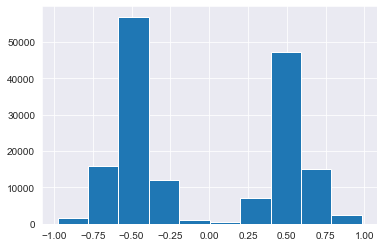

In [34]:
plt.hist(df_all.compound_score)

In [38]:
df_all.compound_score.describe()

count    159488.000000
mean         -0.036101
std           0.524015
min          -0.977094
25%          -0.498465
50%          -0.341504
75%           0.497513
max           0.983665
Name: compound_score, dtype: float64

In [35]:
pd.Series(rescaled.squeeze()).describe()

count    159488.000000
mean         -0.040175
std           0.534502
min          -1.000000
25%          -0.511792
50%          -0.351690
75%           0.504118
max           1.000000
dtype: float64

In [40]:
rescaled = MinMaxScaler((-1, 1)).fit_transform(df_all[['scaled_compound_score']])
pd.Series(rescaled.squeeze()).describe()

count    159488.000000
mean          0.000679
std           0.577045
min          -1.000000
25%          -0.498856
50%           0.000036
75%           0.500269
max           1.000000
dtype: float64

(array([15860., 15991., 15890., 15984., 16016., 15940., 15908., 15926.,
        15984., 15989.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

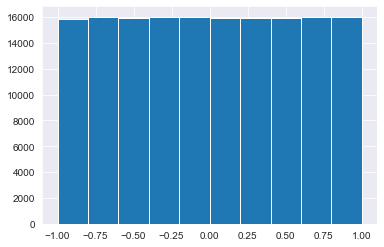

In [41]:
plt.hist(rescaled)